In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import re
from collections import defaultdict
from itertools import combinations
import networkx as nx
import community
from utils.cluster import cluster
from utils.recombinations import recombinations
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from pandas.io.formats.style import Styler
from utils.preprocessing import preprocessing
import os
import seaborn as sns
import igraph as ig
import scipy.stats as stats
import mplcursors
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
from numpy import linalg as LA
from Bio.PDB import PDBParser, Selection, NeighborSearch
from Bio.Seq import Seq
from Bio.SeqUtils import seq1
from Bio.SeqUtils import seq3
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils import nt_search
from Bio.Seq import MutableSeq
import logomaker
import statannot

codontab = {
    'TCA': 'S',    # Serina
    'TCC': 'S',    # Serina
    'TCG': 'S',    # Serina
    'TCT': 'S',    # Serina
    'TTC': 'F',    # Fenilalanina
    'TTT': 'F',    # Fenilalanina
    'TTA': 'L',    # Leucina
    'TTG': 'L',    # Leucina
    'TAC': 'Y',    # Tirosina
    'TAT': 'Y',    # Tirosina
    'TAA': '*',    # Stop
    'TAG': '*',    # Stop
    'TGC': 'C',    # Cisteina
    'TGT': 'C',    # Cisteina
    'TGA': '*',    # Stop
    'TGG': 'W',    # Triptofano
    'CTA': 'L',    # Leucina
    'CTC': 'L',    # Leucina
    'CTG': 'L',    # Leucina
    'CTT': 'L',    # Leucina
    'CCA': 'P',    # Prolina
    'CCC': 'P',    # Prolina
    'CCG': 'P',    # Prolina
    'CCT': 'P',    # Prolina
    'CAC': 'H',    # Histidina
    'CAT': 'H',    # Histidina
    'CAA': 'Q',    # Glutamina
    'CAG': 'Q',    # Glutamina
    'CGA': 'R',    # Arginina
    'CGC': 'R',    # Arginina
    'CGG': 'R',    # Arginina
    'CGT': 'R',    # Arginina
    'ATA': 'I',    # Isoleucina
    'ATC': 'I',    # Isoleucina
    'ATT': 'I',    # Isoleucina
    'ATG': 'M',    # Methionina
    'ACA': 'T',    # Treonina
    'ACC': 'T',    # Treonina
    'ACG': 'T',    # Treonina
    'ACT': 'T',    # Treonina
    'AAC': 'N',    # Asparagina
    'AAT': 'N',    # Asparagina
    'AAA': 'K',    # Lisina
    'AAG': 'K',    # Lisina
    'AGC': 'S',    # Serina
    'AGT': 'S',    # Serina
    'AGA': 'R',    # Arginina
    'AGG': 'R',    # Arginina
    'GTA': 'V',    # Valina
    'GTC': 'V',    # Valina
    'GTG': 'V',    # Valina
    'GTT': 'V',    # Valina
    'GCA': 'A',    # Alanina
    'GCC': 'A',    # Alanina
    'GCG': 'A',    # Alanina
    'GCT': 'A',    # Alanina
    'GAC': 'D',    # Acido Aspartico
    'GAT': 'D',    # Acido Aspartico
    'GAA': 'E',    # Acido Glutamico
    'GAG': 'E',    # Acido Glutamico
    'GGA': 'G',    # Glicina
    'GGC': 'G',    # Glicina
    'GGG': 'G',    # Glicina
    'GGT': 'G'     # Glicina
}
cdrpos = {
# http://www.bioinf.org.uk/abs/info.html#cdrid
# light chain loop positions (chothia)
    'L': {
    'L1' : ['26', '32'],
    'L2' : ['50', '52'],
    'L3' : ['91', '96'],
    },
# heavy chain loop positions (chothia)
    'H': {
    'H1' : ['26', '32'],
    'H2' : ['52', '56'],
    'H3' : ['96', '101']
    }
}

In [3]:
path = '/home/Backup3/DLproject/namphil_codes/all_vaccination'
files = ['pre-35.tsv', '1st-35.tsv', '2nd-35.tsv', '3rd-35_merged.tsv', '4th-35.tsv', '5th-35.tsv']

In [4]:
def checkCDRpos(respos, chain):
    for cdr, pos in cdrpos[chain].items():
        if compare_strings(pos[0], respos) & compare_strings(respos, pos[1]):
            return True, cdr
    return False, None
def inVgene(respos):
    if compare_strings(respos, '113'):
        return True
    return False
def compare_strings(str1, str2):
    # Extract numerical values from the input strings using regular expressions
    num1 = int(re.search(r'\d+', str1).group())
    num2 = int(re.search(r'\d+', str2).group())

    # If the numerical values are equal, compare the remaining parts of the strings
    if num1 == num2:
        alpha1 = re.search(r'[A-Za-z]+', str1).group() if re.search(r'[A-Za-z]+', str1) else ""
        alpha2 = re.search(r'[A-Za-z]+', str2).group() if re.search(r'[A-Za-z]+', str2) else ""

        # Compare the alphabetic parts using string comparison
        return alpha1 <= alpha2

    # Compare the numerical values
    return num1 <= num2
def custom_sort(strings):
    def extract_key(s):
        # Split the string into numeric and non-numeric parts
        parts = re.split(r'(\d+)', s)

        # Convert numeric parts to integers, leave non-numeric parts as they are
        converted_parts = [int(part) if part.isdigit() else part for part in parts]

        return converted_parts

    return sorted(strings, key=extract_key)
def concat_usage(path):
    data = defaultdict(pd.DataFrame)
    for file in os.listdir(path):
        df = preprocessing(pd.read_csv(os.path.join(path, file), sep='\t'))
        v, _, _ = df.get_mature_usage()
        v1, _, _ = df.get_naive_usage()
        mature_data = v.div(v.sum())
        naive_data = v1.div(v1.sum())
        # Combine the data into a single DataFrame
        df = pd.DataFrame({'Naive Repertoire': naive_data, 'Mature Repertoire': mature_data})
        data[file.split('_')[0]] = df
    dataframes = []
    for patient, repertoires in data.items():
        dataframes.append(repertoires)
    combined_df = pd.concat(dataframes)
    return combined_df
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"
def is_pattern_present(input_string, pattern):
    # Replace "_" in the pattern with "." in the regex to match any character
    pattern = str(pattern).replace("_", ".")
    # Create a regex pattern
    regex_pattern = re.compile(pattern)
    # Search for the pattern in the input string
    match = regex_pattern.search(str(input_string))

    return match is not None
def levenshtein_distance(str1, str2):
    str1 = str(str1)
    str2 = str(str2)
    len_str1 = len(str1) + 1
    len_str2 = len(str2) + 1

    # Initialize matrix to store distances
    distance_matrix = [[0 for _ in range(len_str2)] for _ in range(len_str1)]

    # Initialize the first row and column
    for i in range(len_str1):
        distance_matrix[i][0] = i
    for j in range(len_str2):
        distance_matrix[0][j] = j

    # Fill in the matrix
    for i in range(1, len_str1):
        for j in range(1, len_str2):
            cost = 0 if str1[i - 1] == str2[j - 1] else 1

            distance_matrix[i][j] = min(
                distance_matrix[i - 1][j] + 1,      # Deletion
                distance_matrix[i][j - 1] + 1,      # Insertion
                distance_matrix[i - 1][j - 1] + cost  # Substitution
            )

    return distance_matrix[len_str1 - 1][len_str2 - 1]-abs(len_str1-len_str2), abs(len_str1-len_str2)
def sequence_similarity(seq1, seq2):
    sub, indel = levenshtein_distance(seq1, seq2)
    sequence_similarity = pow(0.3, sub) * pow(0.1, indel)
    return sequence_similarity

In [5]:
motifs = [
    Seq('ARDLAAAGGMDV'),
    Seq('ARGLAAAGGMDV'),
    Seq('ARDLQEAGGMDV'),
    Seq('ARDLLEAGGMDV'),
    Seq('ARVRGYSGYGANDAFDI'),
    Seq('ARVHGYSGYGANDAFDL'),
    Seq('ARVRGYSDYGANDAFDI')
]

motif_types = ['CDR3']

no_annot_tot = defaultdict(list)

def get_motif_score(path, files, motif, type):
    output_score = []
    no_annot_tot = defaultdict(list)
    for file in files:
        pre = preprocessing(pd.read_csv(os.path.join(path, file), sep = '\t'))
        df_naive = pre.get_naive()
        df_mature = pre.get_mature()
        # df_naive = df_naive[df_naive['v_call'] == 'IGHV1-69']
        # df_mature = df_mature[df_mature['v_call'] == 'IGHV1-69']
        similarity_score_naive = 0
        similarity_score_mature = 0
        # trim CDRs to match chothia numbering system
        no_annot_naive = []
        no_annot_mature = []
        for i, row in df_naive.iterrows():
            str_pos = []
            seq = Seq(row['sequence_aa'])
            seq_1 = Seq(row['cdr1_aa'][:-1])
            seq_2 = Seq(row['cdr2_aa'][1:-1])
            seq_3 = Seq(row['cdr3_aa'][:-1])
            cdr_pos = [seq.find(seq_1), seq.find(seq_2), seq.find(seq_3)]
            cdr_length = [len(seq_1), len(seq_2), len(seq[seq.find(seq_2) + len(seq_2) : seq.find(seq_3)]), len(seq_3)]
            cdr_length_ori = [int(cdrpos['H']['H1'][1]) - int(cdrpos['H']['H1'][0]) + 1, int(cdrpos['H']['H2'][1]) - int(cdrpos['H']['H2'][0]) + 1, int(cdrpos['H']['H3'][0]) - int(cdrpos['H']['H2'][1]) - 1, int(cdrpos['H']['H3'][1]) - int(cdrpos['H']['H3'][0]) + 1]

            chothia_num = list(range(26 - seq.find(seq_1), 102 + len(seq[seq.find(seq_3) + len(seq_3) :])))
            chothia_num = [str(i) for i in chothia_num]
            duplicate_chothia = ['31', '52', '82', '100']
            for i in range(len(cdr_length)):
                for j in range(cdr_length[i] - cdr_length_ori[i]):
                    chothia_num.append(duplicate_chothia[i] + chr(ord('A') + j))
            chothia_num = custom_sort(chothia_num)
            chothia_num_seq = list(zip(seq, chothia_num))
            for i, (aa, num) in enumerate(chothia_num_seq):
                if num == '26':
                    str_pos.append(i)
                if num == '32':
                    str_pos.append(i)
                if num == '52':
                    str_pos.append(i)
                if num == '56':
                    str_pos.append(i)
                if num == '96':
                    str_pos.append(i)
                if num == '101':
                    str_pos.append(i)
            if len(str_pos)<6:
                no_annot_naive.append(row['sequence_id'])
                continue
            chothiaseq = ''.join([i[0] for i in chothia_num_seq])
            # search for XXX formatted motifs, and append sequence_id to list
            if type =='CDR1':
                similarity_score_naive = similarity_score_naive + sequence_similarity(chothiaseq[str_pos[0]:str_pos[1]+1], motif)
            elif type =='FR2':
                similarity_score_naive = similarity_score_naive + sequence_similarity(chothiaseq[str_pos[1]+1:str_pos[2]], motif)
            elif type =='CDR2':
                similarity_score_naive = similarity_score_naive + sequence_similarity(chothiaseq[str_pos[2]:str_pos[3]+1], motif)
            elif type =='FR3':
                similarity_score_naive = similarity_score_naive + sequence_similarity(chothiaseq[str_pos[3]+1:str_pos[4]], motif)
            elif type =='CDR3':
                similarity_score_naive = similarity_score_naive + sequence_similarity(chothiaseq[str_pos[4]:str_pos[5]+1], motif)
            elif type =='whole':
                similarity_score_naive = similarity_score_naive + sequence_similarity(chothiaseq[str_pos[0]:str_pos[5]+1], motif)

        for i, row in df_mature.iterrows():
            str_pos = []
            seq = Seq(row['sequence_aa'])
            seq_1 = Seq(row['cdr1_aa'][:-1])
            seq_2 = Seq(row['cdr2_aa'][1:-1])
            seq_3 = Seq(row['cdr3_aa'][:-1])
            cdr_pos = [seq.find(seq_1), seq.find(seq_2), seq.find(seq_3)]
            cdr_length = [len(seq_1), len(seq_2), len(seq[seq.find(seq_2) + len(seq_2) : seq.find(seq_3)]), len(seq_3)]
            cdr_length_ori = [int(cdrpos['H']['H1'][1]) - int(cdrpos['H']['H1'][0]) + 1, int(cdrpos['H']['H2'][1]) - int(cdrpos['H']['H2'][0]) + 1, int(cdrpos['H']['H3'][0]) - int(cdrpos['H']['H2'][1]) - 1, int(cdrpos['H']['H3'][1]) - int(cdrpos['H']['H3'][0]) + 1]

            chothia_num = list(range(26 - seq.find(seq_1), 102 + len(seq[seq.find(seq_3) + len(seq_3) :])))
            chothia_num = [str(i) for i in chothia_num]
            duplicate_chothia = ['31', '52', '82', '100']
            for i in range(len(cdr_length)):
                for j in range(cdr_length[i] - cdr_length_ori[i]):
                    chothia_num.append(duplicate_chothia[i] + chr(ord('A') + j))
            chothia_num = custom_sort(chothia_num)
            chothia_num_seq = list(zip(seq, chothia_num))
            for i, (aa, num) in enumerate(chothia_num_seq):
                if num == '26':
                    str_pos.append(i)
                if num == '32':
                    str_pos.append(i)
                if num == '52':
                    str_pos.append(i)
                if num == '56':
                    str_pos.append(i)
                if num == '96':
                    str_pos.append(i)
                if num == '101':
                    str_pos.append(i)

            if len(str_pos)<6:
                no_annot_mature.append(row['sequence_id'])
                continue

            chothiaseq = ''.join([i[0] for i in chothia_num_seq])
            # search for XXX formatted motifs, and append sequence_id to list
            if type =='CDR1':
                similarity_score_mature = similarity_score_mature + sequence_similarity(chothiaseq[str_pos[0]:str_pos[1]+1], motif)
            elif type =='FR2':
                similarity_score_mature = similarity_score_mature + sequence_similarity(chothiaseq[str_pos[1]+1:str_pos[2]], motif)
            elif type =='CDR2':
                similarity_score_mature = similarity_score_mature + sequence_similarity(chothiaseq[str_pos[2]:str_pos[3]+1], motif)
            elif type =='FR3':
                similarity_score_mature = similarity_score_mature + sequence_similarity(chothiaseq[str_pos[3]+1:str_pos[4]], motif)
            elif type =='CDR3':
                similarity_score_mature = similarity_score_mature + sequence_similarity(chothiaseq[str_pos[4]:str_pos[5]+1], motif)
            elif type =='whole':
                similarity_score_mature = similarity_score_mature + sequence_similarity(chothiaseq[str_pos[0]:str_pos[5]+1], motif)

        output_score.append([similarity_score_naive, similarity_score_mature])
        no_annot_tot[file] = [no_annot_naive, no_annot_mature]

    return output_score

score = [get_motif_score(path, files, motif, motif_types[i]) for i, motif in enumerate(motifs)]


pd.DataFrame(score).to_csv('covid_35_all.csv', index=False)

In [7]:
score_df = [[[float(ind.split('[')[1].split(']')[0].split(', ')[0]), float(ind.split('[')[1].split(']')[0].split(', ')[1])] for ind in row ] for row in pd.read_csv('covid_35_all.csv').values.tolist()]
score_df

[[[1.100609247474357, 0.5224187895692015],
  [1.6864547952163096, 0.5453468690986174],
  [2.10935342431488, 1.9849175963514194],
  [0.2976732026526773, 0.12531929502908928],
  [2.290253596185317, 0.9717664456222641],
  [2.1368284804612405, 4.196828082000798]],
 [[1.1677990467965749, 0.43929576124547526],
  [1.676740389455412, 0.5031889385404885],
  [2.1044612360019226, 1.1618374917584553],
  [0.2920458505235028, 0.11180829475217673],
  [2.3268316703054484, 0.9120545721449226],
  [2.171517614994722, 1.862485501025093]],
 [[0.573323589287275, 0.28724569478279477],
  [0.8420785449121245, 0.34897085059234334],
  [1.0873893551002596, 0.6235009045685643],
  [0.13839082139173733, 0.08770103209506144],
  [1.2030259355329593, 0.6853888254883839],
  [1.1036177312128643, 2.39066179787899]],
 [[0.5942824270004226, 0.2981071527650928],
  [0.8834477345916633, 0.3678323188814127],
  [1.1511848846755564, 0.6450070116351687],
  [0.14577416394965845, 0.0916596916419192],
  [1.257653090511609, 0.76713051

In [8]:
data_size = []

def get_file_len(path, files):
    file_len = []
    for file in files:
        df = preprocessing(pd.read_csv(os.path.join(path, file), sep = '\t'))
        naive = df.get_naive()
        mature = df.get_mature()
        # naive = naive[naive['v_call'] == 'IGHV1-69']
        # mature = mature[mature['v_call'] == 'IGHV1-69']
        file_len.append([len(naive), len(mature)])
    return file_len

data_size = get_file_len(path, files)

In [11]:
score_norm = [[[ind[0]/data_size[i][0], ind[1]/data_size[i][1]] for i, ind in enumerate(row)] for row in score_df]
score_norm

[[[1.3063921368748895e-05, 1.3832679047030517e-05],
  [1.4233007243004073e-05, 1.0968580806102646e-05],
  [1.4463476579229843e-05, 2.8070846068524266e-05],
  [1.5716642167512003e-05, 9.561249334637162e-06],
  [1.2520315084408833e-05, 1.1123572825657491e-05],
  [1.373353694573783e-05, 5.240859753494422e-05]],
 [[1.3861445337534124e-05, 1.1631735675205212e-05],
  [1.4151021524828566e-05, 1.0120656862376325e-05],
  [1.442993167856502e-05, 1.6430788586760975e-05],
  [1.54195274827615e-05, 8.530426089278762e-06],
  [1.2720279408852077e-05, 1.0440065614460945e-05],
  [1.3956486291035028e-05, 2.3258101387693315e-05]],
 [[6.805189313541865e-06, 7.605732379664648e-06],
  [7.106807762004275e-06, 7.018863022030679e-06],
  [7.456043301565137e-06, 8.817594215448294e-06],
  [7.306801551834073e-06, 6.691159845507091e-06],
  [6.576679452736722e-06, 7.84547825103174e-06],
  [7.0930236208343895e-06, 2.985379185403152e-05]],
 [[7.0539648062912186e-06, 7.893323609635205e-06],
  [7.455947257480975e-06, 7.3

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Sjogren v.s. Healthy: t-test independent samples with Bonferroni correction, P_val=4.543e-01 stat=7.584e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Sjogren v.s. Healthy: t-test independent samples with Bonferroni correction, P_val=1.095e-02 stat=2.718e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Sjogren v.s. Healthy: t-test independent samples with Bonferroni correction, P_val=1.828e-02 stat=2.501e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Sjogren v.s. Healthy

<Figure size 1000x800 with 0 Axes>

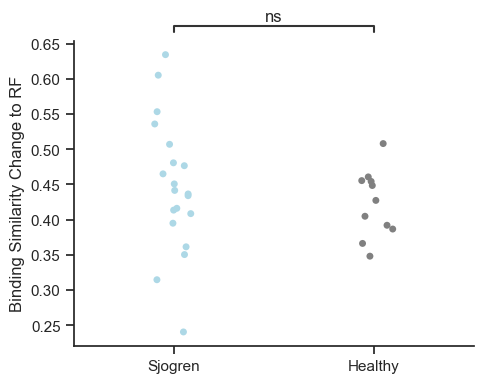

<Figure size 1000x800 with 0 Axes>

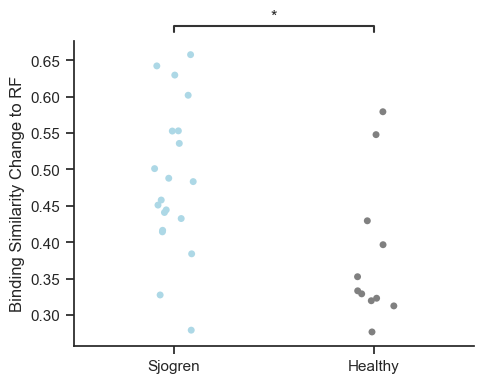

<Figure size 1000x800 with 0 Axes>

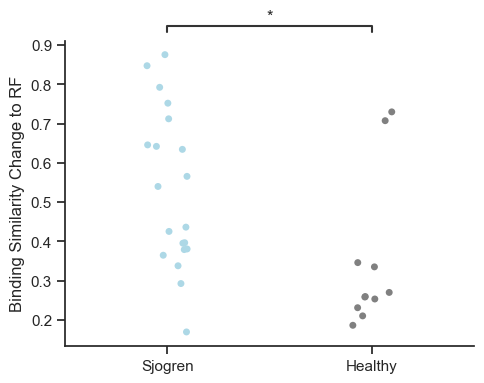

<Figure size 1000x800 with 0 Axes>

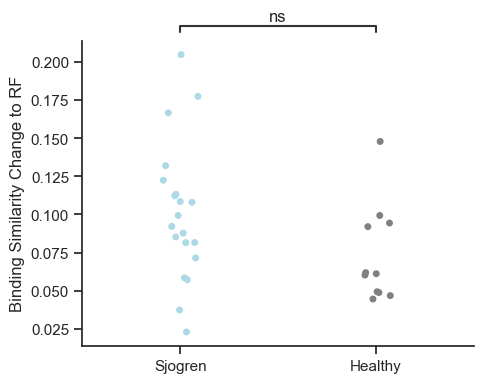

<Figure size 1000x800 with 0 Axes>

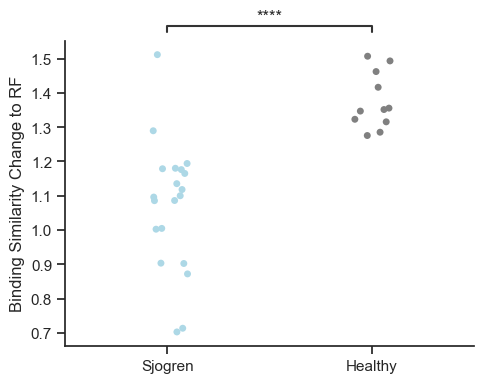

<Figure size 1000x800 with 0 Axes>

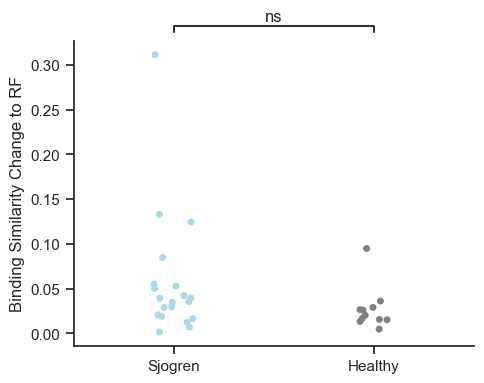

In [54]:
motif_types = ['CDR1', 'FR2', 'CDR2', 'FR3', 'CDR3', 'whole']

score_div = [[sublist[1] / sublist[0] for sublist in row] for row in score_norm]

for ind, scores in enumerate(list(zip(sjogren_score_div, healthy_score_div))):
    plt.figure(figsize=(10, 8))
    sns.set(style="ticks")

    score_df = pd.DataFrame.from_dict({'Sjogren': scores[0], 'Healthy': scores[1]}, orient='index')
    score_df = score_df.T
    # Create a boxplot
    plt.figure(figsize=(5, 4))

    #sns.boxplot(data=score_df, palette="Set3", width = 0.2)

    # Overlay a stripplot for individual data points
    sns.stripplot(data=score_df, jitter=True, edgecolor="gray", palette={'Sjogren': 'lightblue', 'Healthy': 'gray'})

    statannot.add_stat_annotation(
        ax = plt.gca(),
        data=score_df,
        box_pairs=[
            ('Sjogren', 'Healthy')
        ],
        test="t-test_ind",
        text_format="star",
        loc="outside"
    )
    sns.despine()

    plt.ylabel("Binding Similarity Change to RF")
    plt.tight_layout()
    plt.savefig(os.path.join('../Data/Figures/Binding_Similarity/Whole/RF/FC',f'{motif_types[ind]}.png'), dpi=500)